In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import re
import seaborn as sns
from tqdm import tqdm
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize,sent_tokenize
#from fuzzywuzzy import fuzz

train_example_paths = glob.glob('data/train/*.json')
test_example_paths = glob.glob('data/test/*.json')

train_example_names = [fn.split('.')[0] for fn in os.listdir('data/train')]
test_example_names = [fn.split('.')[0] for fn in os.listdir('data/test')]

metadata = pd.read_csv('data/train.csv')
metadata_train = metadata.loc[metadata.Id.isin(train_example_names)]
metadata_test = metadata.loc[metadata.Id.isin(test_example_names)]

metadata = pd.read_csv('data/train.csv')
metadata_train = metadata.loc[metadata.Id.isin(train_example_names)]
metadata_test = metadata.loc[metadata.Id.isin(test_example_names)]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ozan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def clean_text(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower())

def remove_punc(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt))

def get_doc_id(doc_path):
    return os.path.split(train_example_names[0])[-1].split('.')[0]

def load_train_example(i: int):
    doc_path = train_example_paths[i]
    with open(doc_path) as f:
        data = json.load(f)
    return {'doc': data, 'meta': metadata.loc[metadata.Id == get_doc_id(doc_path)]}

def load_train_example_by_name(name):
    doc_path = os.path.join('data/train', name + '.json')
    with open(doc_path) as f:
        data = json.load(f)
    return data

def delete_file(filename):
    if os.path.exists(filename):
        os.remove(filename)

## Split Data

In [3]:
import random

docIdx = train_example_names.copy()
random.seed(42)
random.shuffle(docIdx)

train_ratio = 0.85
n_train = int(len(docIdx) * train_ratio)
n_val = len(docIdx) - n_train

train_idx = docIdx[:n_train]
val_idx = docIdx[n_train:]

print(f'train size: {len(train_idx)}')
print(f'val size: {len(val_idx)}')

train size: 12168
val size: 2148


## Generate Dataset and Features

In [4]:
RE_COMBINE_WHITESPACE = re.compile(r"\s+")

def preprocess_tokenize_doc(doc_json):
    #doc_text = ' '.join([remove_punc(sec['text']) for sec in doc_json])
    doc_text = make_single_whitespace(doc_text)
    
    doc_tokens = doc_text
    return doc_tokens

def indices(lst, element):
    e = element.lower()
    result = [i for i, token in enumerate(lst) if e in token.lower()]
    return result

def make_single_whitespace(text):
    return RE_COMBINE_WHITESPACE.sub(" ", text).strip()

## Create dataframe for tokens and targets

In [5]:
df_cols = ['TOKEN', 'TARGET']

def get_doc(doc_id, reduce_tokens = False):
    doc_labels = list(metadata_train.loc[metadata_train.Id == doc_id, 'dataset_label'].values)
    doc_labels += list(metadata_train.loc[metadata_train.Id == doc_id, 'cleaned_label'].values)
    doc_labels += list(metadata_train.loc[metadata_train.Id == doc_id, 'dataset_title'].values)
    doc_labels = [make_single_whitespace(l.strip()) for l in doc_labels]
    doc_labels = list(set(doc_labels))

    doc_json = load_train_example_by_name(doc_id)

    doc_joined = ' '.join([sec['text'] for sec in doc_json])
    doc_tokens = word_tokenize(doc_joined)
    
    # Targets for dataset names will be 1
    target_arr = np.zeros(len(doc_tokens) ,dtype = 'uint8')

    # Keep n tokens before and after targets
    keep_df = pd.Series(np.zeros(len(doc_tokens), dtype = 'bool'))

    n_total_labels = 0
    for l in doc_labels:
        label_tokens = word_tokenize(l)
        label_tokens_joined = ' '.join(label_tokens)
        n_label_tokens = len(label_tokens_joined)

        doc_tokens_joined = [' '.join(doc_tokens[i:i+n_label_tokens]) for i in range(len(doc_tokens) - n_label_tokens + 1)]
        
        occurrences = indices(doc_tokens_joined, label_tokens_joined)
        if len(occurrences) > 0:
            n_total_labels += 1

            for o in occurrences:
                if reduce_tokens:
                    keep_start = max(0, o - 50)
                    keep_end = min(o + 50 + n_label_tokens, len(doc_tokens))
                    keep_df[keep_start: keep_end] = True
                for i in range(n_label_tokens):
                    target_arr[o + i] = 1

    if n_total_labels == 0:
        return None

    doc_df = pd.DataFrame()
    doc_df['TOKEN'] = doc_tokens
    doc_df['TARGET'] = target_arr
    doc_df['TARGET'] = doc_df['TARGET'].astype('str')
    if reduce_tokens:
        doc_df = doc_df.loc[keep_df]

    return doc_df

In [6]:
import crf_feature_extractor

feature_extractor = crf_feature_extractor.TextFeatureExtractor()

## Create Dataset

In [7]:
# Load dataset names
with open('data/dataset_names.txt', 'r', encoding="utf-8") as f:
    us_dataset_names = f.readlines()
    us_dataset_names = [n for n in us_dataset_names if len(n) > 25] # There are some one word dataset names that are not abbreviations. Dont use them.
    us_dataset_names = [make_single_whitespace(n.strip()) for n in us_dataset_names]

In [8]:
import random

n_examples = len(train_idx)

def replace_target(x, lst):
    if x.TARGET.iloc[0] == '0':
        # if not a dataset name, do not augment
        lst.append(x)
    else:
        random_name_tokens = word_tokenize(random.choice(us_dataset_names))

        new_x = pd.DataFrame()
        # Replace tokens
        new_x['TOKEN'] = random_name_tokens
        new_x['TARGET'] = '1'
        lst.append(new_x)

def Xy_generator(doc_idx, repeat_count, do_augment):
    i_repeat = 0
    while i_repeat < repeat_count:
        i_repeat += 1
        print(f'X_train generator repeat: {i_repeat}')
        for doc_id in tqdm(doc_idx):
            doc_df = get_doc(doc_id, reduce_tokens = True)

            if doc_df is None:
                yield None, None
                continue

            if (i_repeat > 1) and do_augment:
                df_pieces = []
                
                # Do augmentation
                # Replace target tokens
                gb = doc_df.groupby((doc_df.TARGET.shift() != doc_df.TARGET).cumsum())
                for name, group in gb:
                    replace_target(group, df_pieces)

                doc_df = pd.concat(df_pieces, ignore_index= True, axis = 0)

            features = feature_extractor.transform({'output': doc_df})['output'][0]
            targets = list(doc_df.TARGET.values)
            del doc_df
            yield features, targets

def get_dataset(doc_idx, n_repeat, do_augment):
    gen = Xy_generator(doc_idx, n_repeat, do_augment)
    X_list = []
    y_list = []
    n_skipped = 0
    while True:
        try:
            X, y = next(gen)

            if X is None:
                n_skipped += 1
            else:
                X_list.append(X)
                y_list.append(y)
        except StopIteration:
            print('Stop Iteration')
            if do_augment:
                # Shuffle augmented with non-augmented
                perm_idx = list(np.random.permutation(len(X_list)))
                X_list = [X_list[i] for i in perm_idx]
                y_list = [y_list[i] for i in perm_idx]
            break

    print(f'skipped {n_skipped} docs.')
    return X_list, y_list

In [9]:
data = {}
data['train_data'] = get_dataset(train_idx, 2, True)
data['val_data'] = get_dataset(val_idx, 1, False)

  0%|          | 2/2148 [00:00<02:10, 16.39it/s]Stop Iteration
skipped 234 docs.
X_train generator repeat: 1
100%|██████████| 2148/2148 [03:02<00:00, 11.76it/s]Stop Iteration
skipped 21 docs.



## Create CRF Model

In [10]:
from mlmodels import sklearn_model

from sklearn_crfsuite import CRF
from mlmodels.search.hparameters import crf_params

Minimize: False
Best hparameters:
{'algorithm': 'pa', 'all_possible_states': False, 'all_possible_transitions': False, 'averaging': False, 'c': 1.751313862456525, 'epsilon': 0.0016701139581751568, 'error_sensitive': False, 'min_freq': 2, 'pa_type': 1, 'model_class': <class 'sklearn_crfsuite.estimator.CRF'>}
 43%|████▎     | 3/7 [57:11<57:35, 863.79s/trial, best loss: -0.6303117807847275]

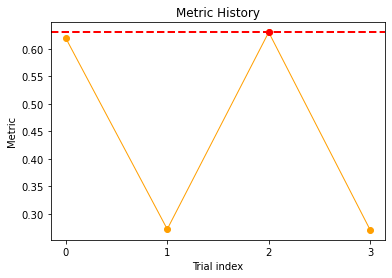

sklearn_model hparameters: {'algorithm': 'ap', 'all_possible_states': True, 'all_possible_transitions': False, 'epsilon': 0.002852198349820592, 'min_freq': 1, 'model_class': <class 'sklearn_crfsuite.estimator.CRF'>}
 57%|█████▋    | 4/7 [57:11<42:13, 844.52s/trial, best loss: -0.6303117807847275]

In [16]:
delete_file('trials_sklearn')

model = sklearn_model.SklearnModel1(minimize_metric = False)

res = model.search(data, crf_params.search_space, crf_params.search_fixed, num_iter = 7)
best_hparams = res['best_params']
best_hparams.update(crf_params.search_fixed)

In [12]:
model = sklearn_model.SklearnModel1(minimize_metric = False, **best_hparams)
res = model.fit(data)

res

sklearn_model hparameters: {'minimize_metric': False, 'algorithm': 'arow', 'all_possible_states': True, 'all_possible_transitions': False, 'epsilon': 0.03403408235182767, 'gamma': 0.282343400664606, 'min_freq': 0, 'variance': 0.7616254342065031, 'model_class': <class 'sklearn_crfsuite.estimator.CRF'>}


{'metric': 0.583413899318749}

In [15]:
model.save()

In [14]:
def get_doc_text(doc_id):
    doc = load_train_example_by_name(doc_id)
    doc_tokens = preprocess_tokenize_doc(doc)
    return ' '.join(doc_tokens)# TODO: unlazy

In [28]:
test_preds = []
ids = []
for doc_id in val_idx[:5]:
    
    # Load and preprocess
    doc = load_train_example_by_name(doc_id)
    doc_tokens = preprocess_tokenize_doc(doc)

    # Extract features
    x = {'output': pd.DataFrame({'TOKEN': doc_tokens})}
    x = feature_extractor.transform(x)

    # Predict
    pred = model.predict([x])
    pred = pred[0]['output'][0]
    pred = np.array([int(p) for p in pred])

    # Token idx
    pos_pred_idx = [i[0] for i in np.argwhere(pred == 1)]
    pred_delimited = []
    if len(pred > 0):
        pred_prev = pos_pred_idx[0]
        for p in pos_pred_idx:
            if p - pred_prev > 3:
                pred_delimited.append(-1)
            
            pred_delimited.append(p)
            pred_prev = p

    # Get corresponding tokens
    pred_tokens = [('|' if i == -1 else doc_tokens[i]) for i in pred_delimited]
    
    pred_joined = ' '.join(pred_tokens)
    pred_tokens = pred_joined.split(' | ')
    preds_joined = list(set(pred_tokens))

    preds_joined_cleaned = preds_joined#[]

    """for p in preds_joined:
        label_similarities = [fuzz.ratio(l, p) for l in labels]
        if max(label_similarities) >= 70:
            preds_joined_cleaned.append(labels[np.argmax(label_similarities)])"""
        
    # 2 options: remove if not similar to any label, or keep without modification

    preds_joined_cleaned = list(set(preds_joined_cleaned))
    test_preds.append('|'.join(preds_joined_cleaned))
    ids.append(doc_id)

sub_df = pd.DataFrame(columns = ['Id', 'PredictionString'])
sub_df['Id'] = ids
sub_df['PredictionString'] = test_preds

In [29]:
pd.options.display.max_rows = 25
pd.options.display.max_colwidth = 150
sub_df

,Id,PredictionString
0,7a9fcb80-85b1-47bb-a3a5-4069c69b4068,adni
1,d6bce360-e056-42ba-9b18-e687407f1661,early childhood longitudinal study
2,09f36a02-f4d1-4fb3-840c-5c7a2285b17c,baltimore longitudinal study of aging
3,9e08d7d3-8f8c-4b0a-9445-f9cfba0813b7,agricultural resource management survey
4,e657b6c3-e32c-4daf-a092-3de500980f37,adni
